In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
!pip install py7zr
import py7zr
import os

if not os.path.exists('/kaggle/train/') :
    os.makedirs('/kaggle/train/')

if not os.path.exists('/kaggle/test/') :
    os.makedirs('/kaggle/test/')

with py7zr.SevenZipFile("/kaggle/input/statoil-iceberg-classifier-challenge/train.json.7z", 'r') as archive:
    archive.extractall(path="/kaggle/train")

with py7zr.SevenZipFile("/kaggle/input/statoil-iceberg-classifier-challenge/test.json.7z", 'r') as archive:
    archive.extractall(path="/kaggle/test")


     |████████████████████████████████| 66 kB 644 kB/s 
     |████████████████████████████████| 124 kB 1.1 MB/s 
     |████████████████████████████████| 1.9 MB 4.6 MB/s 
     |████████████████████████████████| 2.2 MB 6.2 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
df_train = pd.read_json('/kaggle/train/data/processed/train.json')
df_test = pd.read_json('/kaggle/test/data/processed/test.json')

In [4]:
df_train

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0
...,...,...,...,...,...
1599,04e11240,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",na,0
1600,c7d6f6f8,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",na,0
1601,bba1a0f1,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",na,0
1602,7f66bb44,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",na,0


In [5]:
missing = len(df_train[df_train.inc_angle == "na"])
print(np.around(missing/len(df_train) * 100,1) ,'% of the inc_angle data is missing')

8.3 % of the inc_angle data is missing


# reshape images to their original 75x75 size
From the Data Description: "band_1, band_2 - the flattened image data. Each band has 75x75 pixel values in the list, so the list has 5625 elements."

In [6]:
band_1 = np.array([np.array(i).reshape(75,75) for i in df_train['band_1']])
band_2 = np.array([np.array(i).reshape(75,75) for i in df_train['band_2']])

# Composing a thrid band
From the background section: " you will see data with two channels: HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically)."  
Composing a third band of horizontal and vertical feedback should then be as simple as band_3 = band_1 + band_2, since our data is in Decibel which is logarithmic.

In [7]:
band_3 = band_1 + band_2
mean_3 = (band_1 + band_2) / 2

I really should read docs more often. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib.pyplot.imshow
I struggled to understand why the images looked the way they did when i plotted them using imshow.  
As it turnes out, if you give imshow 2D scalar data, it will render as a pseudocolor image where values are mapped to colors using normalization and a colormap.  
So the plots are not representative of what im putting into my model.  
This processing is not done when calling imshow on RGB data, so after creating a pseudo RGB image with the imCreate function the plots changes their appearance again.

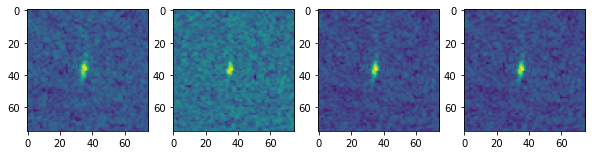

In [8]:
fig, ax = plt.subplots(1,4,figsize = (10,10))
#horizontal feeback
ax[0].imshow(band_1[0])
#vertical feedback
ax[1].imshow(band_2[0])
#combine the two bands to create a full image
ax[2].imshow(band_3[0])
# compose a third band consisting of the mean of the first two bands
ax[3].imshow(mean_3[0])

In [9]:
def createIm(data):
    imgs = []

    for i, row in data.iterrows():
    #make 75x75 image
        b_1 = np.array(row['band_1']).reshape(75, 75)
        b_2 = np.array(row['band_2']).reshape(75, 75)
        b_3 = b_1 + b_2
        #b_3 = np.zeros((75,75))

        
#         a = (b_1 - b_1.mean()) / (b_1.max() - b_1.min())
#         b = (b_2 - b_2.mean()) / (b_2.max() - b_2.min())
#         c = (b_3 - b_3.mean()) / (b_3.max() - b_3.min())

# Rescale to 0 .. 1 range
        r = (b_1 + abs(b_1.min())) / np.max((b_1 + abs(b_1.min())))
        g = (b_2 + abs(b_2.min())) / np.max((b_2 + abs(b_2.min())))
        b = (b_3 + abs(b_3.min())) / np.max((b_3 + abs(b_3.min())))

        imgs.append(np.dstack((r, g, b)))
    return np.array(imgs)

In [10]:
ship = df_train[df_train.is_iceberg == 0]
iceberg = df_train[df_train.is_iceberg == 1]
ship_img = createIm(ship)
iceberg_img = createIm(iceberg)

In [11]:
ship_img.shape

(851, 75, 75, 3)

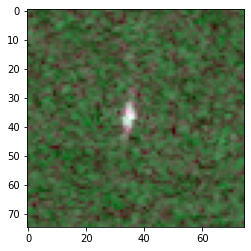

In [12]:
plt.imshow(ship_img[0])

In [13]:
os.makedirs('train/ship')
os.makedirs('train/iceberg')

In [14]:
for i,x in enumerate(ship_img):
    plt.imsave('train/ship/ship_%d.png' % i,x)

for i,x in enumerate(iceberg_img):
    plt.imsave('train/iceberg/iceberg_%d.png' % i,x)

In [15]:
!ls /kaggle/working/train

iceberg  ship


In [16]:
from fastai.imports import *
path = Path('/kaggle/working/train')
Path.BASE_PATH = path
path.ls()

(#2) [Path('ship'),Path('iceberg')]

In [17]:
from fastai.vision.all import *
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2,seed=42, item_tfms=Resize(224))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

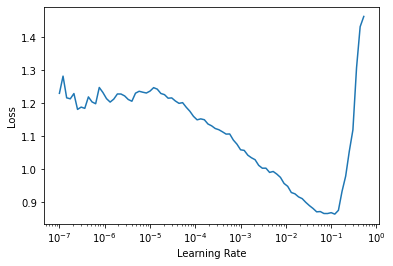

In [18]:
learn = cnn_learner(dls,resnet50, metrics =error_rate, loss_func = CrossEntropyLossFlat())
lr_min,lr_steep = learn.lr_find()

In [19]:
learn.fine_tune(3,base_lr = lr_min)

epoch,train_loss,valid_loss,error_rate,time
0,1.005548,0.528205,0.278125,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.470920,1.308091,0.190625,00:10
1,0.365809,0.409710,0.150000,00:09
2,0.238356,0.282048,0.121875,00:09


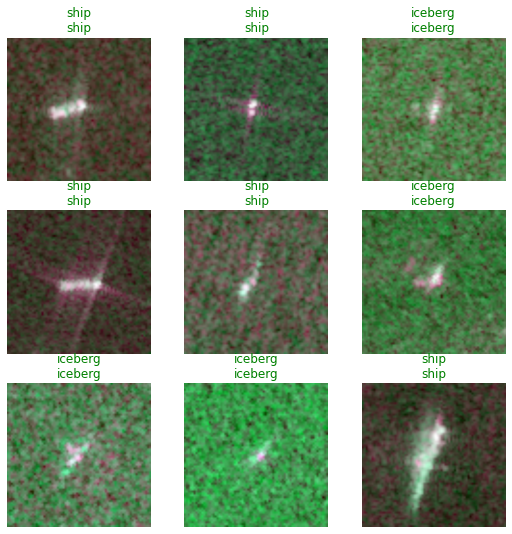

In [20]:
learn.show_results()

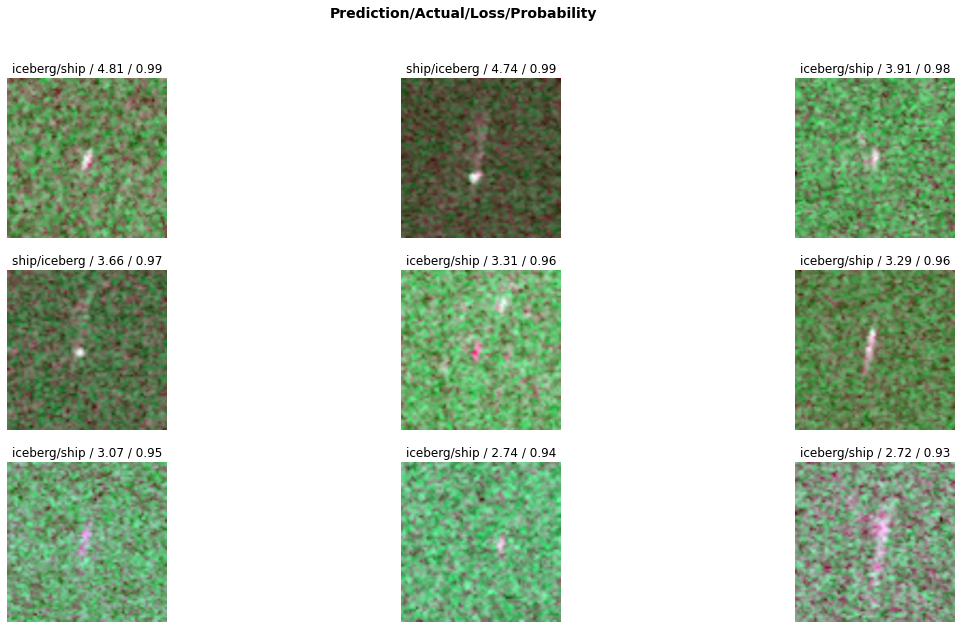

In [21]:
interpreter = ClassificationInterpretation.from_learner(learn)
interpreter.plot_top_losses(9,figsize=(20,10))